# [Exploration 06] 멋진 작사가 만들기
## 01. download data
- 학습할 텍스트 데이터를 다운로드합니다.
- 해당 프로젝트에서는 작사가를 만들기 위해 가사 데이터를 다운로드합니다. 

## 02. load data 
- glob 모듈을 사용해 파일을 읽습니다. 
- 문장 단위로 끊어서 corpus(말뭉치 데이터)를 저장합니다. 

In [1]:
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)
raw_corpus = []

for txt_file in txt_list:
    # with구문으로 txt_list에 있는 txt_file 하나하나를 열어줍니다.
    with open(txt_file, "r") as f:
        # line을 기준으로 문장단위로 끊어서 raw변수에 넣어줍니다.
        raw = f.read().splitlines()
        # 리스트로 생성된 raw는 append가 아닌 extend로 raw_corpus에 더합니다.
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['I. LIFE.', '', '']


## 03. preprocess data 
- 적절한 문장의 길이를 구해서, padding을 하거나 잘라줍니다.
- tf.keras.preprocessing.text.Tokenizer 패키지를 이용해 정제된 데이터를 토큰화합니다.
- 토큰을 모아 사전을 만들고, 숫자로 변환해줍니다.
- 이때 숫자로 변환된 데이터(해당 프로젝트에서는 노래 가사)를 텐서(tensor)라고 합니다.
- 해당 프로젝트에서는 한 문장에 토큰 15개를 권장합니다.

In [2]:
raw_corpus[:15]

['I. LIFE.',
 '',
 '',
 '',
 '',
 '',
 'I.',
 '',
 'SUCCESS.',
 '',
 '[Published in "A Masque of Poets"',
 'at the request of "H.H.," the author\'s',
 'fellow-townswoman and friend.]',
 '',
 'Success is counted sweetest']

In [3]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()      
  
    # 불필요한 특수기호, 공백 등의 패턴을 지우고 공백으로 단어를 토큰화할 수 있도록 정제합니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)    # 패턴의 특수문자 -> 공백
    sentence = re.sub(r'[" "]+', " ", sentence)           # 공백 패턴 -> 스페이스 1개
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도) -> 스페이스 1개

    sentence = sentence.strip()                           
    sentence = '<start> ' + sentence + ' <end>'           # 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

In [4]:
sentence = '[Published in "A Masque of Poets"'
sentence_1 = preprocess_sentence(sentence)
sentence_1

'<start> published in a masque of poets <end>'

In [6]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0:
        continue

    corpus.append(preprocess_sentence(sentence))

corpus[:100]
len(corpus)

175986

In [7]:
import tensorflow as tf

def tokenize(corpus):
    # Tokenizer 패키지를 생성합니다.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 단어장의 크기를 설정합니다. (권장 12,000 이상)      
        filters=' ',      # 별도의 전처리 로직           
        oov_token="<unk>" # out-of-vocabulary, 사전에 없었던 단어            
    )
    tokenizer.fit_on_texts(corpus)   # corpus로부터 Tokenizer가 사전을 구축하는 함수       

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.   
    # maxlen는 시퀀스 길이를 뜻합니다. 지정하지 않을 때는 None이 디폴트값입니다.       
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=50, padding='post')  

    print(tensor,'\n', tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

len(tensor), len(corpus)

[[   2    5   20 ...    0    0    0]
 [   2    5   20 ...    0    0    0]
 [   2 2762   20 ...    0    0    0]
 ...
 [   2    7 1021 ...    0    0    0]
 [   2   30   31 ...    0    0    0]
 [   2   50    5 ...    0    0    0]] 


(175986, 175986)

tokenizer를 통해 토큰화한 tensor data를 확인해보겠습니다.

In [8]:
print(tensor[:10, :12])

[[    2     5    20   102    20     3     0     0     0     0     0     0]
 [    2     5    20     3     0     0     0     0     0     0     0     0]
 [    2  2762    20     3     0     0     0     0     0     0     0     0]
 [    2  9571    14     9     1    19  7664     3     0     0     0     0]
 [    2    71     6  5344    19  1902    20  1902    20     4     6  7665]
 [    2  4379     1     8   308    20     3     0     0     0     0     0]
 [    2  2762    26  5044  2353     3     0     0     0     0     0     0]
 [    2   122   423    97  2267  1114  7666    20     3     0     0     0]
 [    2    10  9572     9  8552     3     0     0     0     0     0     0]
 [    2 11343     1    90    20     3     0     0     0     0     0     0]]


모든 데이터가 2로 시작하고, 3으로 끝나는 것을 알 수 있습니다.    
2와 3이 무엇을 뜻하는지 확인해보겠습니다. 

In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: 
        break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


인덱스 2, 3은 \<start>와 \<end>였습니다. 

## 04. split data
- 학습할 데이터(x-data)와 정답 데이터(y-data)를 만듭니다.
- Dataset객체를 생성합니다.
- 데이터 셋을 train, test로 분할합니다. 

In [10]:
# 소스 문장 : tensor에서 마지막 토큰(<end> or <pad>)을 제외합니다. : <pad>일 가능성이 높습니다. 
src_input = tensor[:, :-1]  
# 타겟 문장 : tensor에서 <start>를 잘라내 생성합니다.
tgt_input = tensor[:, 1:]   

print(src_input[0])
print(tgt_input[0])

[  2   5  20 102  20   3   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5  20 102  20   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [11]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, enc_val = train_test_split(src_input, tgt_input, test_size=0.2)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (140788, 49)
Target Train: (140788, 49)


In [12]:
BUFFER_SIZE = len(src_input)
print(BUFFER_SIZE)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1  # 사전에 포함되지 않은 0:<pad>를 더해줍니다.

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset

175986


<BatchDataset shapes: ((256, 49), (256, 49)), types: (tf.int32, tf.int32)>

In [13]:
BUFFER_SIZE = len(src_input)
print(BUFFER_SIZE)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1  # 사전에 포함되지 않은 0:<pad>를 더해줍니다.

test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, enc_val)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset

175986


<BatchDataset shapes: ((256, 49), (256, 49)), types: (tf.int32, tf.int32)>

## 05. build model
- 10 Epoch 내에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계합니다. 
- 모델은 embedding layer, lstm layer, dense layer로 구성되어있습니다.

In [19]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        # return_sequences = 마지막 출력을 반환할지에 대한 여부 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

input을 모델에 넣으면 input shape가 지정되면서 자동으로 model.build()가 호출됩니다.   
train_dataset의 데이터 하나만 모델에 넣어 테스트합니다.

In [15]:
for src_sample, tgt_sample in train_dataset.take(1): 
    break
model(src_sample)

<tf.Tensor: shape=(256, 49, 12001), dtype=float32, numpy=
array([[[ 1.25659644e-04,  1.05638996e-04,  1.64925543e-04, ...,
         -9.08747534e-05,  1.95486442e-04,  9.62465419e-05],
        [ 6.74160692e-05,  3.34635697e-04,  4.17240284e-04, ...,
         -1.41740922e-04,  1.35734415e-04,  7.56428199e-05],
        [-1.62594461e-05,  5.68517891e-04,  5.85885020e-04, ...,
         -1.57546237e-05, -1.28882966e-05,  1.12312067e-04],
        ...,
        [ 1.78915379e-03, -8.64550588e-04, -8.55218095e-04, ...,
         -3.76240886e-03,  1.84219016e-03, -3.35137651e-04],
        [ 1.78851315e-03, -8.64416361e-04, -8.55824037e-04, ...,
         -3.76546080e-03,  1.84393895e-03, -3.36147088e-04],
        [ 1.78802013e-03, -8.64222588e-04, -8.56327883e-04, ...,
         -3.76801472e-03,  1.84550451e-03, -3.37014964e-04]],

       [[ 1.25659644e-04,  1.05638996e-04,  1.64925543e-04, ...,
         -9.08747534e-05,  1.95486442e-04,  9.62465419e-05],
        [ 1.61236225e-04, -4.44814359e-05,  2

In [16]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1536128   
_________________________________________________________________
lstm (LSTM)                  multiple                  1312768   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  2099200   
_________________________________________________________________
dense (Dense)                multiple                  6156513   
Total params: 11,104,609
Trainable params: 11,104,609
Non-trainable params: 0
_________________________________________________________________


In [20]:
optimizer = tf.keras.optimizers.Adam()        
loss = tf.keras.losses.SparseCategoricalCrossentropy(             
    from_logits=True,             
    reduction='none'        
)        

model.compile(loss=loss, optimizer=optimizer)     
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)     

Epoch 1/10
549/549 [==============================] - 256s 467ms/step - loss: 1.2146 - val_loss: 5.2073
Epoch 2/10
549/549 [==============================] - 263s 480ms/step - loss: 0.9835 - val_loss: 4.7995
Epoch 3/10
549/549 [==============================] - 255s 465ms/step - loss: 0.9286 - val_loss: 4.0683
Epoch 4/10
549/549 [==============================] - 267s 487ms/step - loss: 0.9226 - val_loss: 1.6691
Epoch 5/10
549/549 [==============================] - 264s 480ms/step - loss: 0.8671 - val_loss: 1.5621
Epoch 6/10
549/549 [==============================] - 267s 487ms/step - loss: 0.8368 - val_loss: 1.5647
Epoch 7/10
549/549 [==============================] - 268s 488ms/step - loss: 0.8088 - val_loss: 1.5914
Epoch 8/10
549/549 [==============================] - 267s 487ms/step - loss: 0.7822 - val_loss: 1.6097
Epoch 9/10
549/549 [==============================] - 268s 488ms/step - loss: 0.7571 - val_loss: 1.6365
Epoch 10/10
549/549 [==============================] - 269s 491m

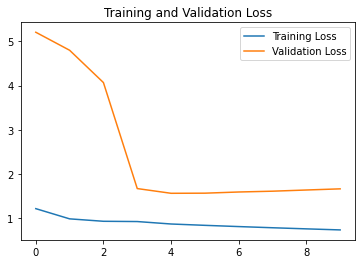

In [21]:
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(loss))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 06. evlauate model
- 문장을 생성해 모델의 성능을 평가합니다. 
- 작문 모델을 평가하기 위해서 생성된 문장을 출력합니다.

In [22]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 입력받은 init_sentence를 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 루프를 돌면서 init_sentence에 살을 붙여나갑니다.
    while True:
        predict = model(test_tensor)   
        # 마지막 단어가 새롭게 예측한 단어입니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   

        # 새롭게 예측한 단어를 init_sentence의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 모델이 <end>를 예측했거나, max_len에 도달하면  while 루프를 탈출해 모델 작동을 멈춥니다.
        if predict_word.numpy()[0] == end_token: 
            break
        if test_tensor.shape[1] >= max_len: 
            break

    generated = ""
    # word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 최종적으로 모델이 생성한 자연어 문장입니다.

노래 가사로 많이 쓰일 법한 말들을 입력 문장으로 넣어줍니다.   
제법 노래가사스러운 작문을 해낸 것을 볼 수 있습니다.

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m not gonna be <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> baby", max_len=20)

'<start> baby , baby , baby , baby , baby , baby , baby , baby , baby , baby '

In [25]:
generate_text(model, tokenizer, init_sentence="<start> cause i want", max_len=20)

'<start> cause i want to be a little selfish <end> '

In [26]:
generate_text(model, tokenizer, init_sentence="<start> i can see", max_len=20)

'<start> i can see you in the club <end> '

In [27]:
generate_text(model, tokenizer, init_sentence="<start> Have yourself a merry", max_len=20)

'<start> have yourself a merry bag , <end> '

다만 영어에서 많이 쓰이는 '(apostrophe)에 대한 처리를 unknown word로 처리하기 때문에,   
전처리 과정에서 이런 문제를 해결해야할 것으로 보입니다.

In [35]:
generate_text(model, tokenizer, init_sentence="<start> I don't want a lot", max_len=20)

'<start> i <unk> want a lot of fame <end> '

# 정리     
---        
1. 데이터 불러오기           
    - 각 파일을 읽은 후, 파일의 문장단위를 저장해 말뭉치(courpus)를 만든다.      
    - glob모듈을 이용해 파일을 쉽게 읽을 수 있다.   
2. 데이터 전처리         
    - 영문을 모두 소문자로 변환한다.                 
    - 특수문자, 공백 패턴 등을 모두 제거한다.                     
    - 단어에 공백을 주어 토큰화가 쉽게해준다.             
3. 데이터 토큰화    
    - 토크나이저 객체를 생성한다.
    - 토크나이저를 통해 사전을 구축하고, 사전에서 tensor로 변환한다. 
4. 데이터 분할       
    - \<start>, \<end> 토큰을 기준으로 슬라이싱해 소스 문장, 타겟 문장을 생성한다.
    - train, test split을 진행한다.
    - tf.data.Dataset을 통해 학습 데이터셋, 평가 데이터셋을 만든다. 
5. 작문 모델 생성          
    - layer를 subclassing하는 방법으로 모델을 생성한다.
    - 모델로 학습을 진행한다. 
6. 모델 성능 평가        
    - 문장의 첫 단어를 입력 문장으로 넣어 학습한 모델로 예측을 한다.
    - 예측된 tensor를 단어로 변환하여, 모델로 생성된 문장을 직접 평가한다. 


# 루브릭 평가
---
1. **가사 텍스트 생성 모델이 정상적으로 동작하는가?**   
    - 실제 영어 노래 가사의 첫 단어를 넣었을 때, 말이 되는 그럴듯한 문장으로 생성되는 것을 볼 수 있었습니다.  
     
     
2. **데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?**  
    - 구성 과정은 **#정리**를 참고하면 진행사항을 참고할 수 있습니다.    
     
     
3. **텍스트 생성모델이 안정적으로 학습되었는가?**  
    - embedding size=256, hidden size=1024로 설정해 epoch 10회를 진행한 결과, validation loss 1.6627 를 달성했습니다.  

    
# 회고
---
## 더 공부하고 싶은 부분
- 아직 **토큰화**에 대해 정확하게 이해를 하지 못한 것 같아 이 부분에 대한 공부가 필요합니다. 

## 느낀 점
해당 모델은 영어로 진행되었기 때문에 언어에 맞는 전처리 과정이 필요하다는 것을 느꼈습니다. 또한 의미있는 문장을 얻기 위해서 문장의 최대 길이를 설정하는 부분이 중요했습니다. 프로젝트 설명에는 15를 권장하였으나, 최대 길이를 15로 했을 때는 너무 짧은 문장이 예측되었기 때문에 50으로 설정해 진행했습니다. 가사라는 것이 곡의 장르에 따라 가사의 종류도 나뉜다고 생각합니다. *예를 들어, 한국의 k-pop의 경우, 의미없는 가사의 반복이 많습니다.* 곡의 종류와 가사를 함께 학습시키면 이런 부분을 해소할 수 있을 것이라고 여겨집니다. 